In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

2024-12-19 17:36:30.471046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 17:36:30.496585: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 17:36:30.496602: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 17:36:30.497285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 17:36:30.501871: I tensorflow/core/platform/cpu_feature_guar

In [3]:
@tfds.decode.make_decoder()
def _decode(image, _):
    return tf.image.decode_jpeg(image, channels=3, dct_method='INTEGER_ACCURATE')    

tfds_precise = tfds.load('imagenet2012', split='validation', decoders={'image': _decode()})

In [4]:
import torchvision
torchvision_default = torchvision.datasets.ImageNet('/data/ImageNet/', split='val')

In [5]:
img_dict = {path.split('/')[-1]: i for i, (path, _) in enumerate(torchvision_default.imgs)}

In [6]:
from torchvision.transforms import v2

In [10]:
result = []
to_image = v2.ToImage()

import numpy as np

def normalized_l2_difference(tf_img, tv_img, factor=2/255):
    h, w, _ = tf_img.shape
    x = tf.transpose(tf_img, perm=[2, 0, 1]).numpy()
    y = tv_img.numpy()
    x, y = np.float64(x), np.float64(y)
    diff = x - y
    sq = (diff ** 2).sum() / h / w
    return np.sqrt(sq) * factor

for data in tfds_precise:
    tf_img = data['image']
    filename = data['file_name']
    index = img_dict[filename.numpy().decode('ascii')]
    tv_img = to_image(torchvision_default[index][0])
    result.append(normalized_l2_difference(tf_img, tv_img))

In [13]:
print(len(result))
print(any(result))
print([x for x in result if x])

50000
True
[0.009118303175637983]


In [14]:
tfds_default = tfds.load('imagenet2012', split='validation')

In [15]:
result = []
for data in tfds_default:
    tf_img = data['image']
    filename = data['file_name']
    index = img_dict[filename.numpy().decode('ascii')]
    tv_img = to_image(torchvision_default[index][0])
    result.append(normalized_l2_difference(tf_img, tv_img))

In [16]:
default = np.array(result)
default.dtype

dtype('float64')

In [17]:
USER = '** redacted **'

filename = f"/home/{USER}/Downloads/default-imagenet-ds-diff"
np.save(filename, default)

In [19]:
# Just the necessary parts of Big Vision
def _resize_factor(image, factor, method="area", antialias=True):
  """Resizes the image by a (float) `factor`, keeping the aspect ratio fixed."""
  h, w = tf.shape(image)[0], tf.shape(image)[1]

  h = tf.cast(tf.round(tf.cast(h, tf.float32) * factor), tf.int32)
  w = tf.cast(tf.round(tf.cast(w, tf.float32) * factor), tf.int32)

  dtype = image.dtype
  tf_dtype = tf.type_spec_from_value(image).dtype
  image = tf.image.resize(image, (h, w), method=method, antialias=antialias)
  return tf.cast(tf.clip_by_value(image, tf_dtype.min, tf_dtype.max), dtype)

def get_resize_small(smaller_size, method="area", antialias=False):
  """Resizes the smaller side to `smaller_size` keeping aspect ratio.

  Args:
    smaller_size: an integer, that represents a new size of the smaller side of
      an input image.
    method: the resize method. `area` is a meaningful, bwd-compat default.
    antialias: see tf.image.resize. Ideally set to True for all new configs.

  Returns:
    A function, that resizes an image and preserves its aspect ratio.

  Note:
    backwards-compat for "area"+antialias tested here:
    (internal link)
  """

  def _resize_small(image):  # pylint: disable=missing-docstring
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    factor = (
        tf.cast(smaller_size, tf.float32) /
        tf.cast(tf.minimum(h, w), tf.float32))
    return _resize_factor(image, factor, method=method, antialias=antialias)
  return _resize_small

def get_central_crop(crop_size=None):
  """Makes central crop of a given size.

  Args:
    crop_size: either an integer H, where H is both the height and width of the
      central crop, or a list or tuple [H, W] of integers, where H and W are
      height and width of the central crop respectively. If `crop_size` is not
      specified, then the largest possible center crop will be taken.

  Returns:
    A function, that applies central crop.
  """
  def _crop(image):
    if crop_size:
      h, w = crop_size[0], crop_size[1]
    else:
      h = w = tf.minimum(tf.shape(image)[0], tf.shape(image)[1])
    dy = (tf.shape(image)[0] - h) // 2
    dx = (tf.shape(image)[1] - w) // 2
    return tf.image.crop_to_bounding_box(image, dy, dx, h, w)

  return _crop

def get_value_range(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False):
  """Transforms a [in_min,in_max] image to [vmin,vmax] range.

  Input ranges in_min/in_max can be equal-size lists to rescale the invidudal
  channels independently.

  Args:
    vmin: A scalar. Output max value.
    vmax: A scalar. Output min value.
    in_min: A scalar or a list of input min values to scale. If a list, the
      length should match to the number of channels in the image.
    in_max: A scalar or a list of input max values to scale. If a list, the
      length should match to the number of channels in the image.
    clip_values: Whether to clip the output values to the provided ranges.

  Returns:
    A function to rescale the values.
  """

  def _value_range(image):
    """Scales values in given range."""
    in_min_t = tf.constant(in_min, tf.float32)
    in_max_t = tf.constant(in_max, tf.float32)
    image = tf.cast(image, tf.float32)
    image = (image - in_min_t) / (in_max_t - in_min_t)
    image = vmin + image * (vmax - vmin)
    if clip_values:
      image = tf.clip_by_value(image, vmin, vmax)
    return image

  return _value_range

rs = get_resize_small(256)
cc = get_central_crop((224, 224))
vr = get_value_range(-1, 1)

In [20]:
import torch
resize = v2.Resize(256)
center_crop = v2.CenterCrop(224)
to_float = v2.ToDtype(torch.float32, scale=True)
value_range = value_range = v2.Normalize(mean=[0.5] * 3, std=[0.5] * 3)

In [21]:
result = []
for data in tfds_default:
    tf_img = data['image']
    tf_img = vr(cc(rs(tf_img)))
    filename = data['file_name']
    index = img_dict[filename.numpy().decode('ascii')]
    tv_img = value_range(
        to_float(
            center_crop(
                resize(
                    to_image(
                        torchvision_default[index][0])))))
    result.append(normalized_l2_difference(tf_img, tv_img, factor=1.))

In [22]:
preprocessed = np.array(result)
preprocessed.dtype

dtype('float64')

In [23]:
filename = f"/home/{USER}/Downloads/preprocessed-imagenet-ds-diff"
np.save(filename, preprocessed)

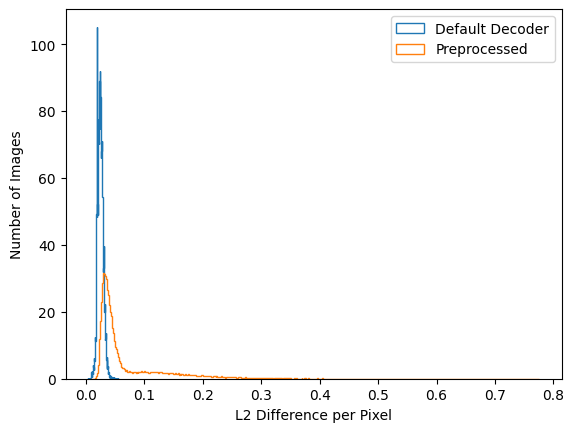

In [27]:
import matplotlib.pyplot as plt

plt.hist(default, 500, density=True, histtype='step', label="Default Decoder")
plt.hist(preprocessed, 500, density=True, histtype='step', label="Preprocessed")

plt.legend(loc="upper right")
plt.xlabel("L2 Difference per Pixel")
plt.ylabel("Number of Images")
plt.savefig(f"/home/{USER}/Downloads/imagenet-ds-diff.png")
plt.show()